<a href="https://colab.research.google.com/github/orekhovsky/GenAI-mini-projects/blob/main/speech_detestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/whisper.git

In [ ]:
import torch
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from google.colab import files
import whisper
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

In [1]:
# загружаем audio.ogg
uploaded = files.upload()

Saving audio.ogg to audio.ogg


In [6]:
# Переносим на GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

audio_path = 'audio.ogg'
audio, sr = librosa.load(audio_path, sr=None)

# Сохранение в WAV
wav_path = 'audio.wav'
sf.write(wav_path, audio, sr)

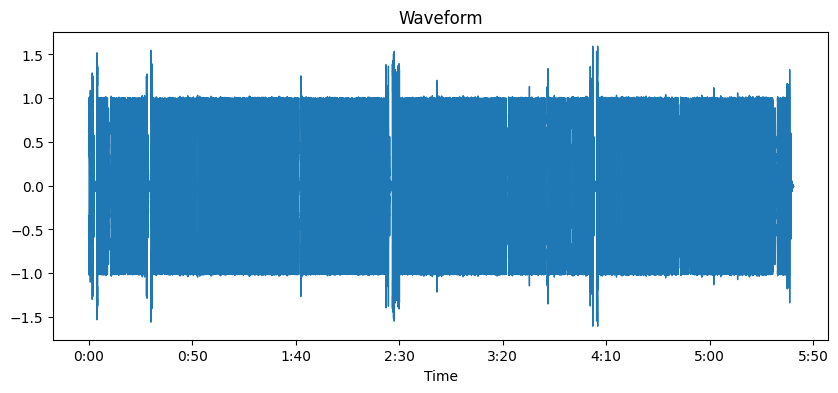

<ipython-input-3-f5216469af67>:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


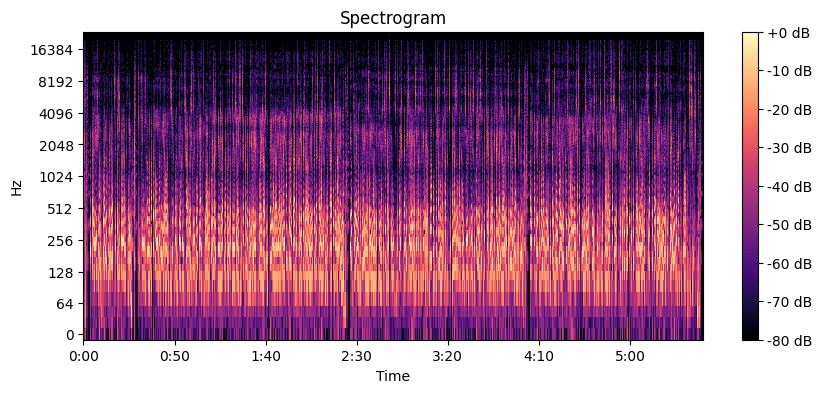

In [3]:
# Волновая форма
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.show()

# Спектрограмма
D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()


In [8]:
whisper_model = whisper.load_model("small").to(device)  # Модель small для меньших ресурсов
result = whisper_model.transcribe(wav_path)
print(result['text'])

 Всем привет! Это подкаст от Сбер инвестиций и с вами его ведущий Евгений Шматко. Мы выходим два раза в неделю и рассказываем о самых важных событиях на рынке. Наша задача – помочь вам разобраться с инвестициями. Сезон отчетности продолжается и сегодня мы обсудим операционные результаты UGK, позитив технологис и ленты. Начнем с первой компании. В пятницу российский золото добытчик UGK представил операционные результаты за четвертый квартал. Производство желтого металла во втором полугодии снизилось год к году на 22% и на 4% к первой половине прошлого года. Причина – закрытие ряда месторождения на Уральском Хабе, потребованию рост технадзора. Объем производства на Уральском Хабе в июле-декабре сократился на 69% год к году. В то же время на Сибирском Хабе производство увеличилось на 28%. Тем не менее, это на 12% ниже, чем прогноз компании, которая озвучила в августе. По итогам года производство золота сократилось на 17%, причем снижение отмечают уже второй год подряд. В этом году UGK жде

# Извлечение MFCC-признаков
Разбиваем аудио на сегменты (например, по 1–2 секунды)
Извлекаем MFCC для каждого сегмента

In [10]:
audio_path = 'audio.wav'
audio, sr = librosa.load(audio_path, sr=16000)  # 16 kHz для ASR

# Разбиваем на сегменты по 1.5 секунды
segment_length = int(1.5 * sr)  # 1.5 секунды
segments = []
mfcc_features = []

# Извлечение MFCC признаков
for i in range(0, len(audio), segment_length):
    segment = audio[i : i + segment_length]

    if len(segment) < segment_length:
        break  # Обрезаем, если последний кусок слишком мал

    # Извлечение MFCC признаков
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
    mfcc_features.append(np.mean(mfcc, axis=1))  # Усредняем по времени
    segments.append(segment)

mfcc_features = np.array(mfcc_features)
print("Размерность MFCC признаков:", mfcc_features.shape)

Используем устройство: cuda
Размерность MFCC признаков: (226, 13)


In [11]:
whisper_model = whisper.load_model("small").to(device)

transcriptions = []
for i, segment in enumerate(segments):
    temp_path = f"temp_{i}.wav"
    sf.write(temp_path, segment, sr)  # Сохраняем сегмент

    # Транскрибация с помощью Whisper
    result = whisper_model.transcribe(temp_path)
    transcriptions.append(result["text"])

print("Примеры транскрипции Whisper:", transcriptions[:5])


/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


Примеры транскрипции Whisper: [' you', '', ' Всем привет!', ' Это подкаст от Сбир инвести...', ' и с вами его ведет.']


Попробуем обучить модель LSTM распознавать речь и транскрибировать её (это было так наивно)!

In [24]:
# Токенизация транскрипций
# Формируем множество символов из всех транскрипций
chars = sorted(set("".join(transcriptions)))
# Резервируем индекс 0 для blank (в CTCLoss blank=0)
char_to_idx = {c: i+1 for i, c in enumerate(chars)}
idx_to_char = {i+1: c for i, c in enumerate(chars)}

# Преобразуем каждую транскрипцию в последовательность индексов
tokenized_transcriptions = []
target_lengths = []
for t in transcriptions:
    tokens = [char_to_idx[c] for c in t if c in char_to_idx]
    tokenized_transcriptions.append(torch.tensor(tokens, dtype=torch.long))
    target_lengths.append(len(tokens))

# Преобразовываем MFCC признаки в тензор (форма: [batch, T, feature_dim])
X = torch.tensor(mfcc_features, dtype=torch.float32).to(device)  # форма: (N, T, 13)
# Длина последовательности для каждого примера
input_lengths = [X.shape[1] for _ in range(X.shape[0])]

# Разбиваем данные на обучающую и тестовую выборки по индексам
indices = list(range(len(X)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_train = X[train_idx]
X_test = X[test_idx]
tokenized_train = [tokenized_transcriptions[i] for i in train_idx]
tokenized_test = [tokenized_transcriptions[i] for i in test_idx]
target_lengths_train = [target_lengths[i] for i in train_idx]
target_lengths_test = [target_lengths[i] for i in test_idx]
input_lengths_train = [input_lengths[i] for i in train_idx]
input_lengths_test = [input_lengths[i] for i in test_idx]

# Для CTCLoss необходимые цели – это 1D тензор, объединяющий все последовательности
targets_train = torch.cat(tokenized_train).to(device)
target_lengths_train = torch.tensor(target_lengths_train, dtype=torch.long).to(device)
input_lengths_train = torch.tensor(input_lengths_train, dtype=torch.long).to(device)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out)  # Классификатор для каждого временного шага
        return output

hidden_size = 128  # Размер скрытого слоя
output_size = len(char_to_idx) + 1  # Уникальные символы + blank (0)

model = LSTMModel(input_size=13, hidden_size=hidden_size, output_size=output_size).to(device)

# Используем CTCLoss, который подходит для задач ASR с нестыкующими длинами последовательностей
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Прямой проход: выходы имеют форму (batch, T, output_size)
    outputs = model(X_train)
    outputs = F.log_softmax(outputs, dim=2)  # Требуется для CTCLoss
    outputs = outputs.transpose(0, 1)  # Переставляем, чтобы получить (T, batch, output_size)

    loss = criterion(outputs, targets_train, input_lengths_train, target_lengths_train)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Эпоха [{epoch+1}/{epochs}], Потери: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    outputs = model(X_test)  # (batch, T, output_size)
    outputs = F.log_softmax(outputs, dim=2)
    outputs = outputs.transpose(0, 1)  # (T, batch, output_size)

    # на каждом временном шаге выбираем наиболее вероятный символ
    y_pred = outputs.argmax(dim=2).transpose(0, 1)  # (batch, T)

    predicted_texts = []
    for sequence in y_pred:
        decoded = []
        prev_token = None
        for token in sequence:
            token = token.item()
            # Удаляем повторения и пропускаем blank (0)
            if token != 0 and token != prev_token:
                decoded.append(idx_to_char[token])
            prev_token = token
        predicted_texts.append("".join(decoded))

    print("Примеры предсказанных текстов:", predicted_texts[:5])

Используем устройство: cuda
Размерность MFCC признаков: (226, 47, 13)


/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


Примеры транскрипции Whisper: [' you', '', ' Всем привет!', ' Это подкаст от Сбир инвести...', ' и с вами его ведет.']
Эпоха [1000/10000], Потери: 1.1079
Эпоха [2000/10000], Потери: 0.2468
Эпоха [3000/10000], Потери: 0.0764
Эпоха [4000/10000], Потери: 0.0406
Эпоха [5000/10000], Потери: 0.0214
Эпоха [6000/10000], Потери: 0.0240
Эпоха [7000/10000], Потери: 0.0099
Эпоха [8000/10000], Потери: 0.0062
Эпоха [9000/10000], Потери: 0.0039
Эпоха [10000/10000], Потери: 1.0257
Примеры предсказанных текстов: [' васомпудптотоко.а рдотиривед..и', ' ет  .тсклаацен%н. ', '  арват вуарресосон', ' икаоарлая .в к с. .ык', ' лаа.амапаибпоавквцлвго.']


# Вывод
Разумеется, получилась ерунда, но посмотреть было интересно. Данных слишком мало для обучения, плюс модель посимвольная, что усложняет воспроизводимость слов.